<a href="https://colab.research.google.com/github/TechWithEva/AlurasStore_Analysis_Challenge1/blob/main/Challenge1_Alura'sStores_Eva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge-1_Alura's Store**

Durante este desafío, ayudarás al Sr. Juan a decidir qué tienda de su cadena Alura Store debe vender para iniciar un nuevo emprendimiento. **El objetivo es identificar la tienda menos eficiente y presentar una recomendación final basada en los datos.**

Para ello, *se analizaran los datos de las 4 tiendas en términos de volumen de ventas, rendimiento y reseñas.*







In [159]:
!pip install plottable

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Integración de Datos y Tratamiento

In [160]:
def transformaFecha(base, attr)->datetime:
  return pd.to_datetime(base[attr], format='%d/%m/%Y')

def constructorListas(base, attr)->list:
  return sorted(base[(attr).strip()].unique().tolist())

### 2.1 Integración de orígenes de datos

In [161]:
url1=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv')
url2=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv')
url3=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv')
url4=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv')

base_t1 = pd.read_csv(url1,sep=',')
base_t2 = pd.read_csv(url2,sep=',')
base_t3 = pd.read_csv(url3,sep=',')
base_t4 = pd.read_csv(url4,sep=',')

#display(base_t1.head())
#display(base_t2.head())
#display(base_t3.head())
#display(base_t4.head())

In [162]:
#Generar un identificador de tienda para integrar los datos en un sólo archivo
base_t1.insert(0,'Tienda', 1)
base_t2.insert(0,'Tienda', 2)
base_t3.insert(0,'Tienda', 3)
base_t4.insert(0,'Tienda', 4)

#display(base_t1.head())
#display(base_t2.head())
#display(base_t3.head())
#display(base_t4.head())

In [163]:
#verificamos el tamaño en filas y columnas de cada base 2359 con 13 columnas, excepto por la tienda 4 que tiene 2358 filas
#print(base_t1.shape)
#print(base_t2.shape)
#print(base_t3.shape)
#print(base_t4.shape)

#procedemos a integrar los df en una  sola base
frames = [base_t1, base_t2, base_t3, base_t4]
bd_tiendas = pd.concat(frames)
#renombramos algunas columnas
bd_tiendas.rename(columns={'Categoría del Producto': 'ProductoCategoria','Precio': 'TrnVenta','Calificación': 'TrnCalificacion','Costo de envío':'TrnCostoEnvio','Fecha de Compra':'TrnFecha','Método de pago':'TrnMetodoPago','Cantidad de cuotas':'TrnCuotas','lat':'CiudadLatitud','lon':'CiudadLongitud','Lugar de Compra':'TrnCiudadDestino'}, inplace=True)
#agregamos un identificador de transaccion
bd_tiendas.insert(0, 'TransaccionID', range(1, len(bd_tiendas) + 1))
#verificamos la integración
#bd_tiendas.info()
#bd_tiendas.describe()

### 2.2 Tratamiento del conjunto de datos

#### 2.2.1 Tratamiento de datos nulos


In [164]:
nulos=bd_tiendas.isnull().sum().sum() #no hay nulos

#### 2.2.2 Tratamiento de duplicados

In [165]:
bd_tiendas.drop_duplicates(inplace=True) #no hay duplicados ya que resultan la misma cantidad de filas

#### 2.2.3 Tratamiento de formatos de fechas

In [166]:
#ya que el atributo es una cadena en el archivo original, nos aseguramos que todos los valores puedan convertirse a datetime para garantizar que todos los campos son fechas válidas
bd_tiendas['TrnFecha'] = transformaFecha(bd_tiendas,'TrnFecha')
#procedemos a derivar una columna para identificar los trimestres de ventas
bd_tiendas.insert(5, 'TrnAnio', bd_tiendas['TrnFecha'].dt.year)
bd_tiendas.insert(6, 'TrnMes', bd_tiendas['TrnFecha'].dt.month)
bd_tiendas.insert(7, 'TrnTrimestre', bd_tiendas['TrnFecha'].dt.quarter)

#### Tratamiento de información incompleta

In [167]:
#El archivo contiene la información de los años 2020 al 2023, pero el 2023 únicamente tiene informacion para el primer cuarto de año por lo que se va a excluir
bd_tiendas = bd_tiendas[bd_tiendas['TrnAnio'] != 2023]

## Funciones auxiliares


#### Funciones de Cálculo

In [168]:
def conteoGlobal(base, attrAgrupamiento, Attr)->list:
  posiblesGrupos = sorted(bd_tiendas[attrAgrupamiento].unique().tolist())
  recuentoAgrupado = base.groupby(attrAgrupamiento)[Attr].count()
  recuentosIndexados = recuentoAgrupado.reindex(posiblesGrupos, fill_value=0)
  return recuentosIndexados.tolist()

def conteoGlobalUnique(base, attrAgrupamiento, Attr)->list:
  return base.groupby(attrAgrupamiento)[Attr].nunique().tolist()

def sumasGlobales(base, attrAgrupamiento, attrCalculo)->list:
  return base.groupby(attrAgrupamiento)[attrCalculo].sum().round(2).tolist()

def promedioGlobal(base, attrAgrupamiento, attrCalculo)->list:
  return base.groupby(attrAgrupamiento)[attrCalculo].mean().round(2).tolist()

def conteoDesglose(base, attrAgrupamiento, Attr)->list:
  return base.groupby(attrAgrupamiento)[Attr].count().round(2).reset_index()

def AgregacionDesglose(base, listaAttrAgrupamiento,attrCalculo)->pd.DataFrame:
  return base.groupby(listaAttrAgrupamiento)[attrCalculo].sum().round(2).reset_index()

def PromedioPorListaAtributos(base, listaAttrAgrupamiento,attrCalculo)->pd.DataFrame:
  datos_agrupados=base.groupby(listaAttrAgrupamiento)[attrCalculo].mean().round(2).reset_index()
  datos_agrupados['Total']=datos_agrupados[attrCalculo].mean()
  return datos_agrupados

def topTransacciones(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento, group_keys=False)[AttrAgregacion].count().reset_index(name='Cantidad')
  t_sorted = t.sort_values(by=['Cantidad',attrOrdenamiento], ascending=[False,True])
  topcito = t_sorted.groupby(attrOrdenamiento, group_keys=False).head(topn).reset_index(drop=True)
  return topcito

def topVentas(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento, group_keys=False)[AttrAgregacion].sum().reset_index(name='Ventas')
  ts = t.sort_values(by=['Ventas', attrOrdenamiento], ascending=[False, True]).head(topn).reset_index(drop=True)
  return ts

def topVentasListAtrr(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento)[AttrAgregacion].sum().reset_index(name='Ventas')
  ts = t.sort_values(by=['Ventas',attrOrdenamiento], ascending=[False,True])
  topcitoVentas = ts.groupby(attrOrdenamiento, group_keys=False).head(topn).reset_index(drop=True)
  return topcitoVentas

## 3. Análisis del conjunto de datos

### Cálculos Generales

In [169]:
#Datos Globales
#¿Cúantas transaciones se realizan por cada tienda?
totalTransaccionesxTienda = conteoGlobal(bd_tiendas,'Tienda','TransaccionID')
#¿Cúanto son los ingresos de ventas por cada una de las tiendas?
totalIngresosxTienda = sumasGlobales(bd_tiendas,'Tienda','TrnVenta')
#Promedio Costos de Envío
promedioCostosEnvioxTienda = promedioGlobal(bd_tiendas,'Tienda','TrnCostoEnvio')
#Indice de Satisfacción del Cliente
promedioSatisfaccionxTienda = promedioGlobal(bd_tiendas,'Tienda','TrnCalificacion')
#Alcance de Tienda -cantidad de ciudades
totalAlcancexTienda = conteoGlobalUnique(bd_tiendas,'Tienda','TrnCiudadDestino')
#Cantidad de Categorias que maneja cada tienda
totalCategoriasxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','ProductoCategoria')
#Cantidad de Productos que maneja cada tienda
totalProductosxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','Producto')
#Monto Global de Ventas
montoGlobalVentas = sum(totalIngresosxTienda)
#Monto Global de Costos de Envío
totalGlobalTransacciones = sum(totalTransaccionesxTienda)
#Media de Transacciones
mediaTransacciones = mean(totalTransaccionesxTienda)
#Media de ventas
mediaVentas = mean(totalIngresosxTienda)
#Media de Costos de Envío
mediaCostosEnvio = mean(promedioCostosEnvioxTienda)
#Media de Satisfacción del Cliente
mediaSatisfaccion = mean(promedioSatisfaccionxTienda)
#Detección de Transacciones Atípicas
ventasEnCero = conteoGlobal(bd_tiendas[bd_tiendas['TrnVenta'] == 0],'Tienda','TransaccionID')
costosEnvioEnCero = conteoGlobal(bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0],'Tienda','TransaccionID')
#Empleados por Tienda
totalEmpleadosxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','Vendedor')

#### 3.1 Ingresos por Tienda <Análisis de Rendimiento>

In [170]:
#Rendimiento de Ingresos por tienda
rendimiento_total_tienda = {'TIENDA': constructorListas(bd_tiendas,'Tienda')
                           ,'TOTAL_TRANSACCIONES': totalTransaccionesxTienda
                           ,'INGRESOS_TOTALES': totalIngresosxTienda
                           ,'PROMEDIO_COSTOS_ENVIO': promedioCostosEnvioxTienda
                           ,'PROMEDIO_SATISFACCION': promedioSatisfaccionxTienda
                           }
base_rendimiento_tienda = pd.DataFrame(rendimiento_total_tienda)
base_rendimiento_tienda['%INGRESOS'] = ((base_rendimiento_tienda['INGRESOS_TOTALES'].astype(float) / montoGlobalVentas)*100).round().astype(int)
base_rendimiento_tienda['%TRANSACCIONES'] = ((base_rendimiento_tienda['TOTAL_TRANSACCIONES'].astype(float) / totalGlobalTransacciones)*100).round().astype(int)
base_rendimiento_tienda['VENTAS_EN_CERO'] = ventasEnCero
base_rendimiento_tienda['COSTOS_ENVIO_EN_CERO'] = costosEnvioEnCero
base_rendimiento_tienda['CATEGORIAS_PRODUCTOS'] = totalCategoriasxTienda
base_rendimiento_tienda['PRODUCTOS'] = totalProductosxTienda
base_rendimiento_tienda['ALCANCE_CIUDADES'] = totalAlcancexTienda
base_rendimiento_tienda['VENDEDORES'] = totalEmpleadosxTienda

In [171]:
#Desglose de datos por Tienda
#Comportamiento para cada Tienda por año
#Transacciones por año
totalTransaccionesxTiendaAnio = conteoDesglose(bd_tiendas,['Tienda','TrnAnio'],'TransaccionID')
#Ventas por año
totalVentasxTiendaAnio = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda'],'TrnVenta')
totalVentasxTiendaTrimestral = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda','TrnTrimestre'],'TrnVenta')
#Ventas por Producto - Categoria
transaccionesCeroCosto = bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0].groupby(['Tienda', 'Producto'])['TransaccionID'].count().reset_index(name='TrnCeroCosto')
totalVentasxTiendaProducto = AgregacionDesglose(bd_tiendas,['Tienda','Producto','ProductoCategoria'],'TrnVenta')
totalVentasxTiendaProducto['%VentaTienda'] = (totalVentasxTiendaProducto['TrnVenta'] / totalVentasxTiendaProducto.groupby('Tienda')['TrnVenta'].transform('sum')*100).round(2)
totalVentasxTiendaProducto['%Satisfaccion'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCalificacion'].mean().round(2).reset_index(drop=True)
totalVentasxTiendaProducto = totalVentasxTiendaProducto.merge(transaccionesCeroCosto, on=['Tienda', 'Producto'], how='left')
totalVentasxTiendaProducto['CostoEnvioMaximo'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCostoEnvio'].max().reset_index(drop=True)
totalVentasxTiendaProducto['CostoEnvioMinimo'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCostoEnvio'].min().reset_index(drop=True)
totalVentasxTiendaProducto['TrnSinCostoEnvio'] = totalVentasxTiendaProducto['TrnCeroCosto'].fillna(0).astype(int)
totalVentasxTiendaProducto.drop(columns=['TrnCeroCosto'], inplace=True)
totalVentasxTiendaProducto['TrnxProducto'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TransaccionID'].count().reset_index(drop=True)
totalVentasxTiendaProducto['%TrnSinCosto'] = (totalVentasxTiendaProducto['TrnSinCostoEnvio'] / totalVentasxTiendaProducto['TrnxProducto'] * 100).round(2)
totalVentasxTiendaProducto.sort_values(by=['TrnVenta','Tienda'], ascending=[False,True], inplace=True)
totalVentasxTiendaProducto['DistribucionAlcance'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCiudadDestino'].nunique().reset_index(drop=True)
base_rendimiento_tienda_desglosado = pd.DataFrame(totalVentasxTiendaProducto)

#### 3.2 Análisis de %Satisfacción de Clientes por Tienda

In [172]:
#¿Cúal es el promedio de satisfacción del cliente con el servicio en cada tienda?
base_rendimiento_tienda[['TIENDA','PROMEDIO_SATISFACCION']]

,TIENDA,PROMEDIO_SATISFACCION
0,1,3.98
1,2,4.04
2,3,4.05
3,4,3.98


In [173]:
#¿Ciudades con mayores indices de satisfacción?
satisfaccion_por_TiendaCiudad = PromedioPorListaAtributos(bd_tiendas,['TrnCiudadDestino'],'TrnCalificacion').sort_values(by=(['TrnCalificacion']), ascending=False)
satisfaccion_por_TiendaCiudad.rename(columns={'Total': 'Promedio'}, inplace=True)

In [174]:
#¿Promedio de satisfacción por cada vendedor?
satisfaccion_por_EmpleadoTienda = PromedioPorListaAtributos(bd_tiendas,['Vendedor'],'TrnCalificacion')
satisfaccion_por_EmpleadoTienda.rename(columns={'Total': 'Promedio'}, inplace=True)

#### 3.3 Análisis de Comportamiento de Gasto Promedio de Envío por cada Tienda

In [175]:
#¿Cúal es el promedio de costos de envío por Tienda
base_rendimiento_tienda[['TIENDA','PROMEDIO_COSTOS_ENVIO']]

,TIENDA,PROMEDIO_COSTOS_ENVIO
0,1,25762.90
1,2,25325.66
2,3,25300.78
3,4,23754.29


In [176]:
#¿Costo de envío promedio por ciudad
promedioCostoEnvioPorCiudad = PromedioPorListaAtributos(bd_tiendas,['TrnCiudadDestino','Tienda'],'TrnCostoEnvio')
promedioCostoEnvioPorCiudad.rename(columns={'Total': 'Promedio'}, inplace=True)

In [177]:
#Costo de Envío por Producto
base_rendimiento_tienda_desglosado[['Tienda','Producto','CostoEnvioMaximo', 'CostoEnvioMinimo']]

,Tienda,Producto,CostoEnvioMaximo,CostoEnvioMinimo
48,1,TV LED UHD 4K,160800.0,84700.0
39,1,Refrigerador,137000.0,76700.0
76,2,Iphone 15,140500.0,69000.0
99,2,TV LED UHD 4K,162500.0,80800.0
150,3,TV LED UHD 4K,158400.0,80200.0
...,...,...,...,...
121,3,Dinosaurio Rex,9700.0,0.0
16,1,Cubo mágico 8x8,9800.0,0.0
118,3,Cubo mágico 8x8,5800.0,0.0
67,2,Cubo mágico 8x8,7400.0,0.0


#### 3.4 Análisis de Comportamiento de Ventas por Categoría

In [178]:
#Categorias más populares por tienda?
agrupamiento1 = base_rendimiento_tienda_desglosado.groupby(['Tienda', 'ProductoCategoria'])[['TrnxProducto','TrnVenta']].agg('sum','sum').reset_index()
top5CategoriasxTienda = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])
top5CategoriasxTienda.rename(columns={'TrnxProducto': 'CantidadProductosVendidos'}, inplace=True)

#### 3.5 Análisis de Comportamiento de Ventas por Producto en cada Tienda

In [179]:
#Productos más y menos populares por tienda
agrupamiento1 = base_rendimiento_tienda_desglosado.groupby(['Tienda', 'Producto'])[['TrnxProducto','TrnVenta']].agg('sum','sum').reset_index()
top5ProductosMasVendidos = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])
top5ProductosMenosVendidos = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=True).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])


Resumenes Empleados

In [180]:
#¿Rendimiento por empleado?
transaccionesCeroCosto = bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0].groupby(['Tienda', 'Vendedor'])['TransaccionID'].count().reset_index(name='TrnCeroCosto')
totalVentasPorEmpleadoTienda = AgregacionDesglose(bd_tiendas,['Vendedor','Tienda'],'TrnVenta')
totalVentasPorEmpleadoTienda['Porcentaje'] = (totalVentasPorEmpleadoTienda['TrnVenta'].astype(float) / totalVentasPorEmpleadoTienda.groupby('Tienda')['TrnVenta'].transform('sum').astype(float) * 100).round(2)
totalVentasPorEmpleadoTienda['%Satisfaccion'] = bd_tiendas.groupby(['Vendedor', 'Tienda'])['TrnCalificacion'].mean().reset_index(drop=True)
totalVentasPorEmpleadoTienda['Transacciones'] = bd_tiendas.groupby(['Vendedor', 'Tienda'])['TransaccionID'].transform('count').reset_index(drop=True)
totalVentasPorEmpleadoTienda = totalVentasPorEmpleadoTienda.merge(transaccionesCeroCosto, on=['Tienda', 'Vendedor'], how='left')
totalVentasPorEmpleadoTienda['TrnSinCostoEnvio'] = totalVentasPorEmpleadoTienda['TrnCeroCosto'].fillna(0).astype(int)
totalVentasPorEmpleadoTienda.drop(columns=['TrnCeroCosto'], inplace=True)
base_rendimiento_empleados = pd.DataFrame(totalVentasPorEmpleadoTienda)
top5EmpleadosMasProductivos = base_rendimiento_empleados.sort_values(by=['TrnVenta'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','Vendedor'], ascending=[True,False,True])
top5EmpleadosMenosProductivos = base_rendimiento_empleados.sort_values(by=['TrnVenta'], ascending=True).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','Vendedor'], ascending=[True,False,True])
totalVentasxEmpleadoTrimestral = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda','TrnTrimestre','Vendedor'],'TrnVenta')
totalVentasEmptrimestral1y2  = totalVentasxEmpleadoTrimestral[(totalVentasxEmpleadoTrimestral['TrnAnio'] == 2021) | (totalVentasxEmpleadoTrimestral['TrnAnio'] == 2022) & (totalVentasxEmpleadoTrimestral['Tienda'] == 1) | (totalVentasxEmpleadoTrimestral['Tienda'] == 2)]
display(totalVentasEmptrimestral1y2)

,TrnAnio,Tienda,TrnTrimestre,Vendedor,TrnVenta
56,2020,2,1,Beatriz Morales,8697700.0
57,2020,2,1,Blanca Ramirez,2859500.0
58,2020,2,1,Camila Rivera,8120700.0
59,2020,2,1,Felipe Santos,10924500.0
60,2020,2,1,Izabela de León,2363000.0
...,...,...,...,...,...
555,2022,2,4,Mariana Herrera,5970900.0
556,2022,2,4,Pedro Gomez,2731800.0
557,2022,2,4,Rafael Acosta,8070500.0
558,2022,2,4,Santiago Silva,9284800.0


## 4. Viz por tipo de Análisis

## Resumenes Por Tienda
* ### Rendimiento
* ### Satisfacción del Cliente
* ### Costos de Envío

In [181]:
display(base_rendimiento_tienda)

,TIENDA,TOTAL_TRANSACCIONES,INGRESOS_TOTALES,PROMEDIO_COSTOS_ENVIO,PROMEDIO_SATISFACCION,%INGRESOS,%TRANSACCIONES,VENTAS_EN_CERO,COSTOS_ENVIO_EN_CERO,CATEGORIAS_PRODUCTOS,PRODUCTOS,ALCANCE_CIUDADES,VENDEDORES
0,1,2167,1.047620e+09,25762.90,3.98,26,25,0,189,8,51,19,14
1,2,2167,1.029909e+09,25325.66,4.04,25,25,0,199,8,51,19,14
2,3,2181,1.035100e+09,25300.78,4.05,25,25,0,189,8,51,19,14
3,4,2201,9.808928e+08,23754.29,3.98,24,25,0,184,8,51,19,14


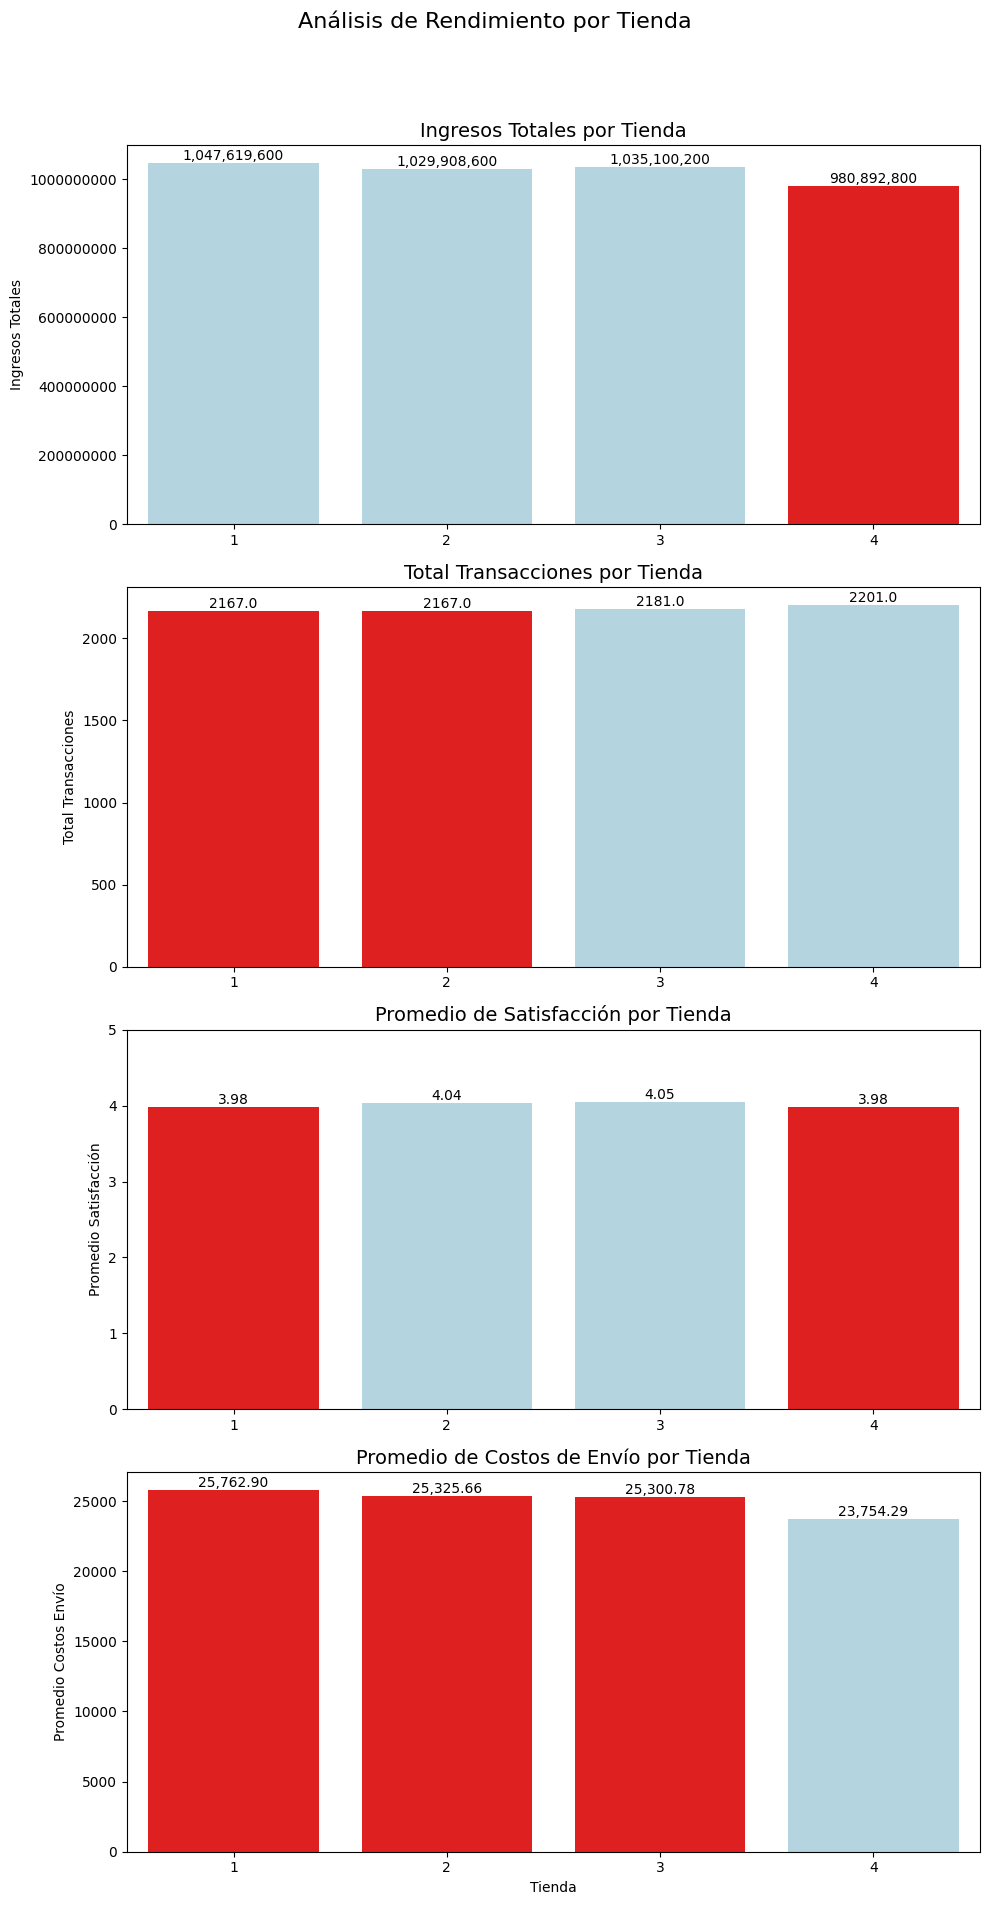

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns


ingresoPromedioGlobalTienda = base_rendimiento_tienda['INGRESOS_TOTALES'].mean()
transaccionesPromedioGlobalTienda = base_rendimiento_tienda['TOTAL_TRANSACCIONES'].mean()
satisfaccionPromedioGlobalTienda = base_rendimiento_tienda['PROMEDIO_SATISFACCION'].mean()
costoEnvioPromedioGlobalTienda = base_rendimiento_tienda['PROMEDIO_COSTOS_ENVIO'].mean()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
fig.suptitle('Análisis de Rendimiento por Tienda', fontsize=16)

# Plot 1: Ingresos Totales
colorsIngresos = ['red' if val < ingresoPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['INGRESOS_TOTALES']]
sns.barplot(x='TIENDA', y='INGRESOS_TOTALES', data=base_rendimiento_tienda, ax=axes[0], palette=colorsIngresos, hue='TIENDA', legend=False)
axes[0].set_title('Ingresos Totales por Tienda', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ingresos Totales')
axes[0].ticklabel_format(style='plain', axis='y')
for index, row in base_rendimiento_tienda.iterrows():
    axes[0].text(index, row['INGRESOS_TOTALES'], f'{row['INGRESOS_TOTALES']:,.0f}', color='black', ha="center", va='bottom')

# Plot 2: Total Transacciones
colorsTransacciones = ['red' if val < transaccionesPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['TOTAL_TRANSACCIONES']]
sns.barplot(x='TIENDA', y='TOTAL_TRANSACCIONES', data=base_rendimiento_tienda, ax=axes[1], palette=colorsTransacciones, hue='TIENDA', legend=False)
axes[1].set_title('Total Transacciones por Tienda', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Transacciones')
for index, row in base_rendimiento_tienda.iterrows():
    axes[1].text(index, row['TOTAL_TRANSACCIONES'], f'{row['TOTAL_TRANSACCIONES']}', color='black', ha="center", va='bottom')

# Plot 3: Promedio Satisfacción
colorsSatisfaccion = ['red' if val < satisfaccionPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['PROMEDIO_SATISFACCION']]
sns.barplot(x='TIENDA', y='PROMEDIO_SATISFACCION', data=base_rendimiento_tienda, ax=axes[2], palette=colorsSatisfaccion, hue='TIENDA', legend=False)
axes[2].set_title('Promedio de Satisfacción por Tienda', fontsize=14)
axes[2].set_xlabel('')
axes[2].set_ylabel('Promedio Satisfacción')
axes[2].set_ylim(0, 5)
for index, row in base_rendimiento_tienda.iterrows():
    axes[2].text(index, row['PROMEDIO_SATISFACCION'], f'{row['PROMEDIO_SATISFACCION']:.2f}', color='black', ha="center", va='bottom')

# Plot 4: Promedio Costos de Envío
colorsCostosEnvio = ['red' if val > costoEnvioPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['PROMEDIO_COSTOS_ENVIO']]
sns.barplot(x='TIENDA', y='PROMEDIO_COSTOS_ENVIO', data=base_rendimiento_tienda, ax=axes[3], palette=colorsCostosEnvio, hue='TIENDA', legend=False)
axes[3].set_title('Promedio de Costos de Envío por Tienda', fontsize=14)
axes[3].set_xlabel('Tienda')
axes[3].set_ylabel('Promedio Costos Envío')
axes[3].ticklabel_format(style='plain', axis='y')
for index, row in base_rendimiento_tienda.iterrows():
    axes[3].text(index, row['PROMEDIO_COSTOS_ENVIO'], f'{row['PROMEDIO_COSTOS_ENVIO']:,.2f}', color='black', ha="center", va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

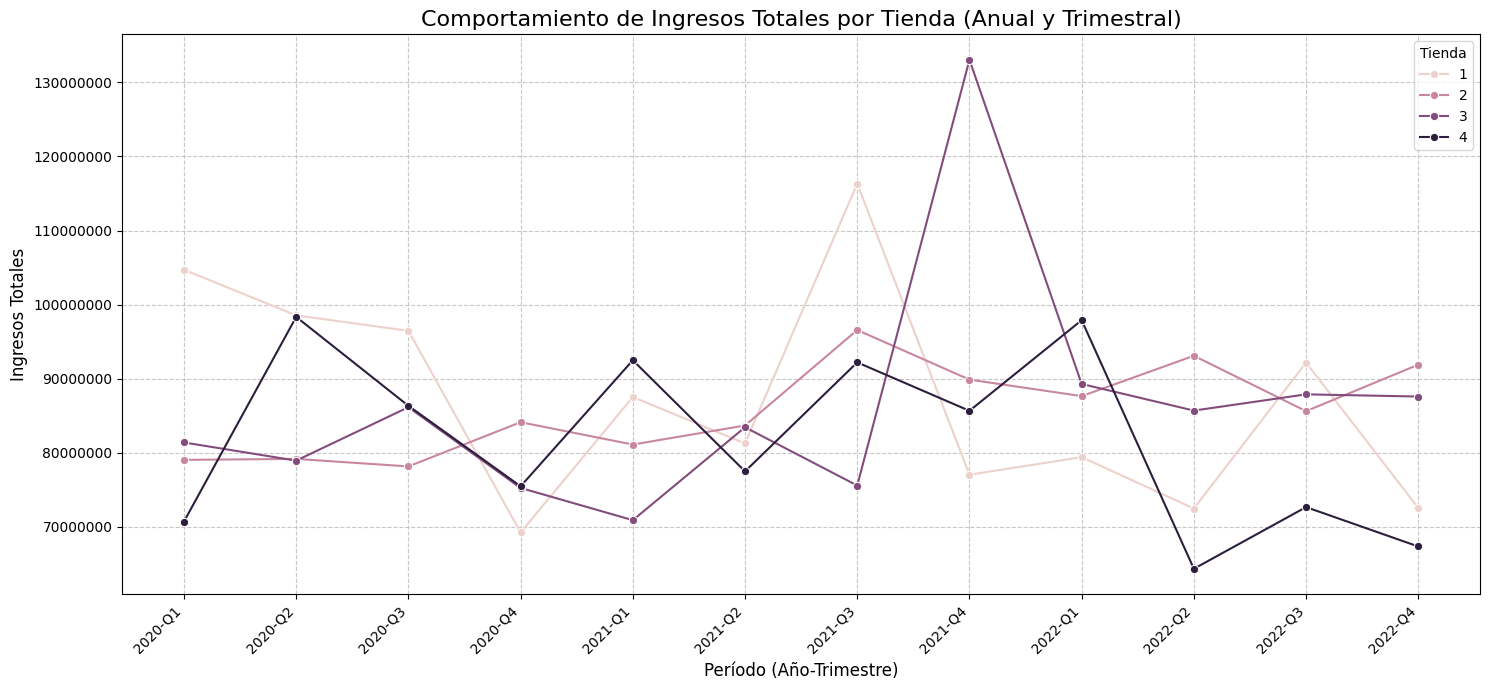

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

totalVentasxTiendaTrimestral['Periodo'] = totalVentasxTiendaTrimestral['TrnAnio'].astype(str) + '-Q' + totalVentasxTiendaTrimestral['TrnTrimestre'].astype(str)
totalVentasxTiendaTrimestral_sorted = totalVentasxTiendaTrimestral.sort_values(by=['TrnAnio', 'TrnTrimestre'])
plt.figure(figsize=(15, 7))
sns.lineplot(x='Periodo', y='TrnVenta', hue='Tienda', data=totalVentasxTiendaTrimestral_sorted, marker='o')
plt.title('Comportamiento de Ingresos Totales por Tienda (Anual y Trimestral)', fontsize=16)
plt.xlabel('Período (Año-Trimestre)', fontsize=12)
plt.ylabel('Ingresos Totales', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [185]:
display (base_rendimiento_tienda)

,TIENDA,TOTAL_TRANSACCIONES,INGRESOS_TOTALES,PROMEDIO_COSTOS_ENVIO,PROMEDIO_SATISFACCION,%INGRESOS,%TRANSACCIONES,VENTAS_EN_CERO,COSTOS_ENVIO_EN_CERO,CATEGORIAS_PRODUCTOS,PRODUCTOS,ALCANCE_CIUDADES,VENDEDORES
0,1,2167,1.047620e+09,25762.90,3.98,26,25,0,189,8,51,19,14
1,2,2167,1.029909e+09,25325.66,4.04,25,25,0,199,8,51,19,14
2,3,2181,1.035100e+09,25300.78,4.05,25,25,0,189,8,51,19,14
3,4,2201,9.808928e+08,23754.29,3.98,24,25,0,184,8,51,19,14


Análisis de Rendimiento por Tienda:

En las primeras visualizaciones podemos verificar que las tiendas representan cada una +/- 25% de ingresos de la Empresa.
A pesar que existe una ligera diferencia del 2% de ventas que representa ***$66,726,800.00***
entre la tienda que más ingresos tiene ***Tienda 1 [$1,047,619,600.00]***
y la que menos Ingresos tiene ***Tienda 4 [$980,892,800]***
a pesar de esto se mantiene por debajo del promedio de ventas de las otras 3 tiendas ***[$1,023,380,300]***.
En cuanto a otras características como:

|Perspectiva|Descripción de Hallazgo|
|--|:--|
|Cantidad de Transacciones|Tienen un número similar promedio de transacciones. Aunque la 4 se marca la diferencia son sólo 34 transacciones y estás tampoco representan un ingreso de ventas destacado|
|Satisfacción|Todas las tiendas tienen un promedio similar. \Pero se debe prestar atención a la Tienda 1 y 4 que están por debajo del promedio de satisfacción Global por Tienda|
|Costos de Envío|La tienda 4 representa la de menor costo de envío pero se ha detectado que a pesar de está caracteristica y de que también ofrecen productos a costo cero todas las tiendas no se compensa el rendimiento|
|Alcance de Ventas|Todas las tiendas tienen presencia en 19 ciudades|
|Manejo de Almacén|Todas mantienen la misma cantidad de productos (51) y categorías (8)|
|Fuerza de Venta|Todas las Tiendas combinan la fuerza de (14) empleados|

A pesar de que en este análisis preliminar se ha detectado que la Tienda #4 es la de menor rendimiento, también al momento de desglosar los datos se han encontrado los siguientes hallazgos:
1. La tienda #1 y Tienda #4 comparten los mismos patrones de ventas a través de los Trimestres evaluados en los años 2020 al 2022. ***Se ha detectado que los empleados prestan más atención a una u otra tienda sin seguir un comportamiento costante. Pero las actividades de la Tienda 1 se mantienen más o menos estables.




*****Basándonos en el análisis de ingresos y transacciones, la Tienda 4 se perfila como la menos eficiente. A pesar de tener el mayor número de transacciones, sus ingresos totales son los más bajos de todas las tiendas. Además, comparte el promedio de satisfacción más bajo con la Tienda 1. Aunque tiene el menor promedio de costos de envío, esto no es suficiente para compensar su bajo rendimiento en ingresos y satisfacción del cliente.*****


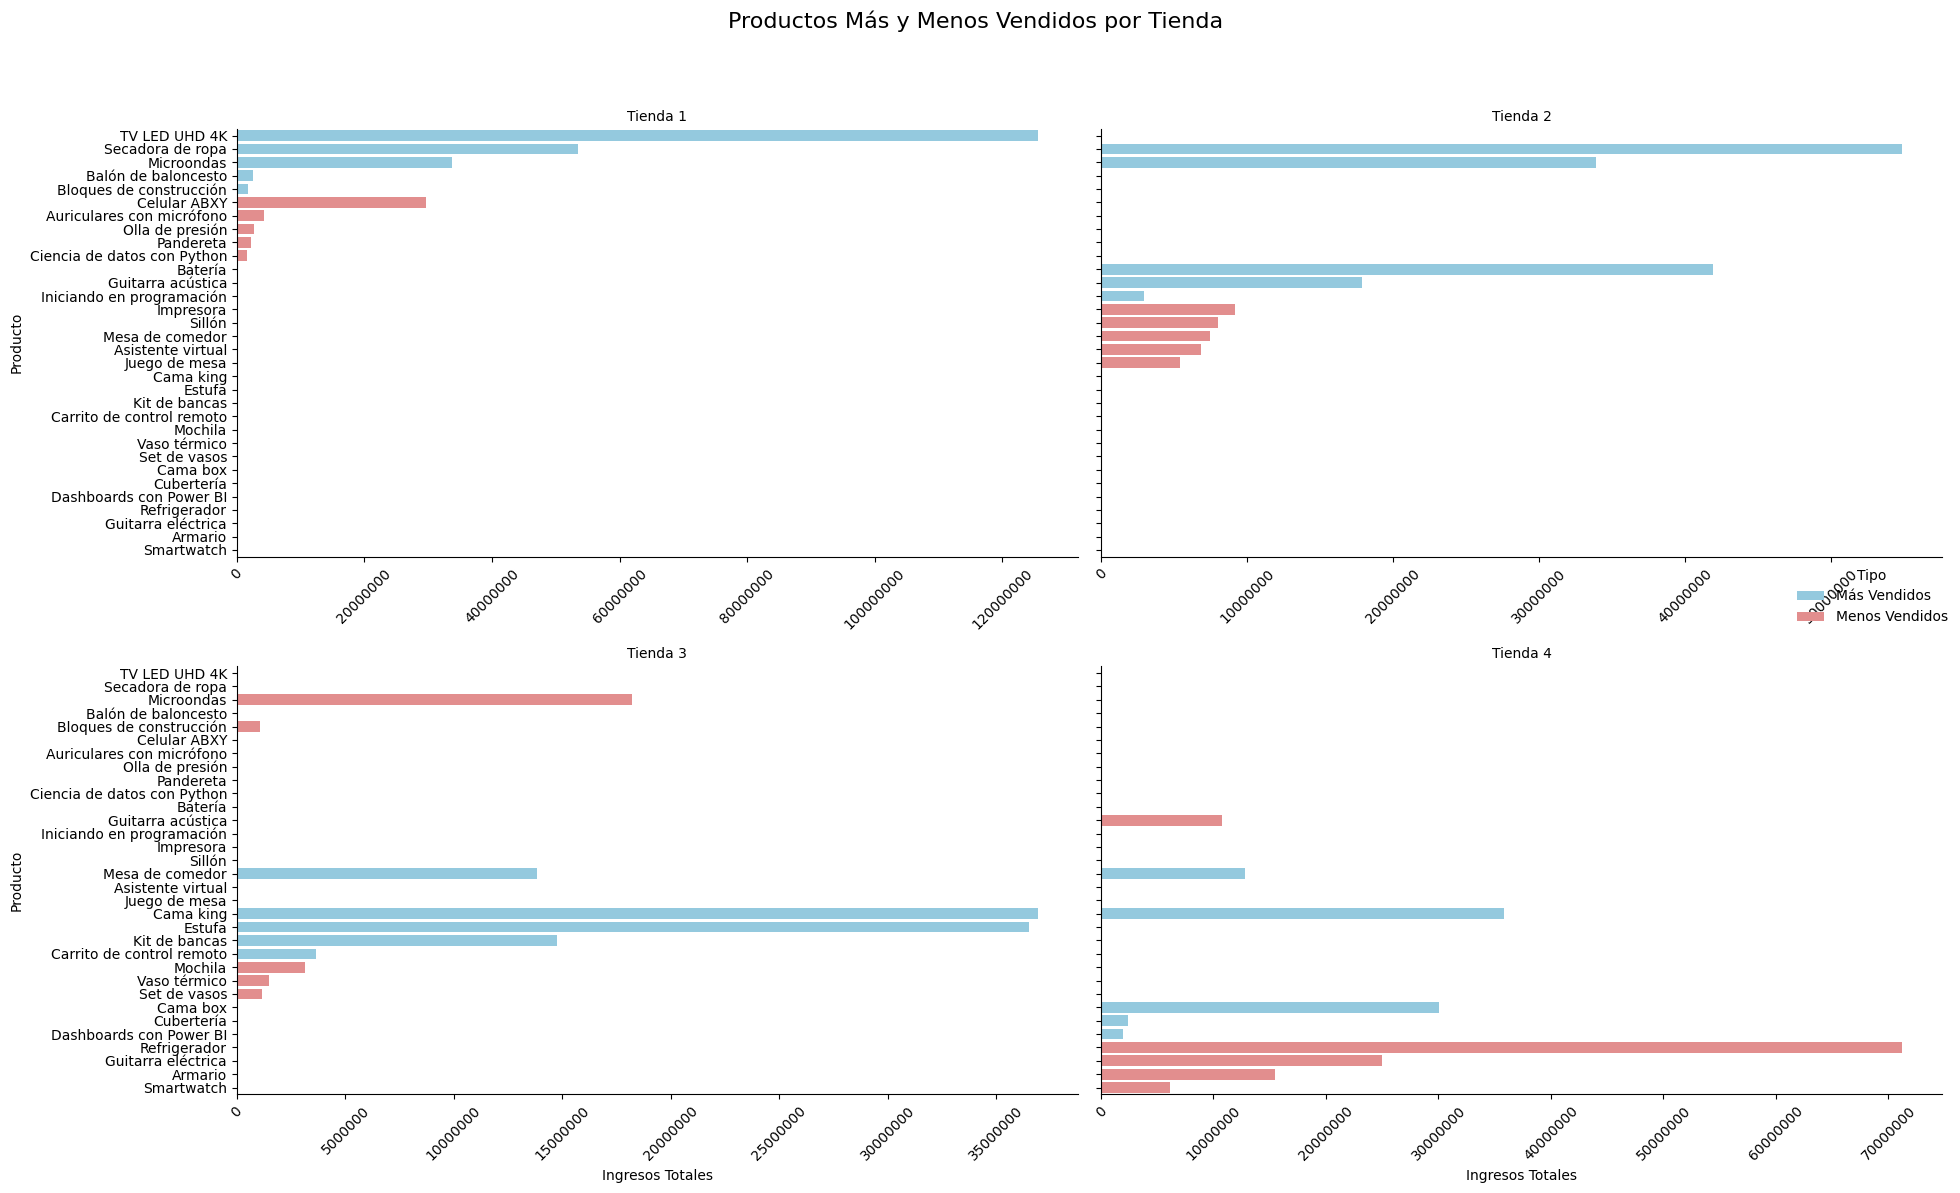

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

top5ProductosMasVendidos['Tipo'] = 'Más Vendidos'
top5ProductosMenosVendidos['Tipo'] = 'Menos Vendidos'
combined_products = pd.concat([top5ProductosMasVendidos, top5ProductosMenosVendidos])
combined_products_sorted = combined_products.sort_values(by=['Tienda', 'Tipo', 'TrnVenta'], ascending=[True, False, False])
g = sns.catplot(
    data=combined_products_sorted,
    x='TrnVenta',
    y='Producto',
    hue='Tipo',
    col='Tienda',
    kind='bar',
    col_wrap=2,
    sharex=False,
    height=6, aspect=1.5,
    palette={'Más Vendidos': 'skyblue', 'Menos Vendidos': 'lightcoral'}
)

g.set_axis_labels('Ingresos Totales', 'Producto')
g.set_titles('Tienda {col_name}')
for ax in g.axes.flat:
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('Productos Más y Menos Vendidos por Tienda', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

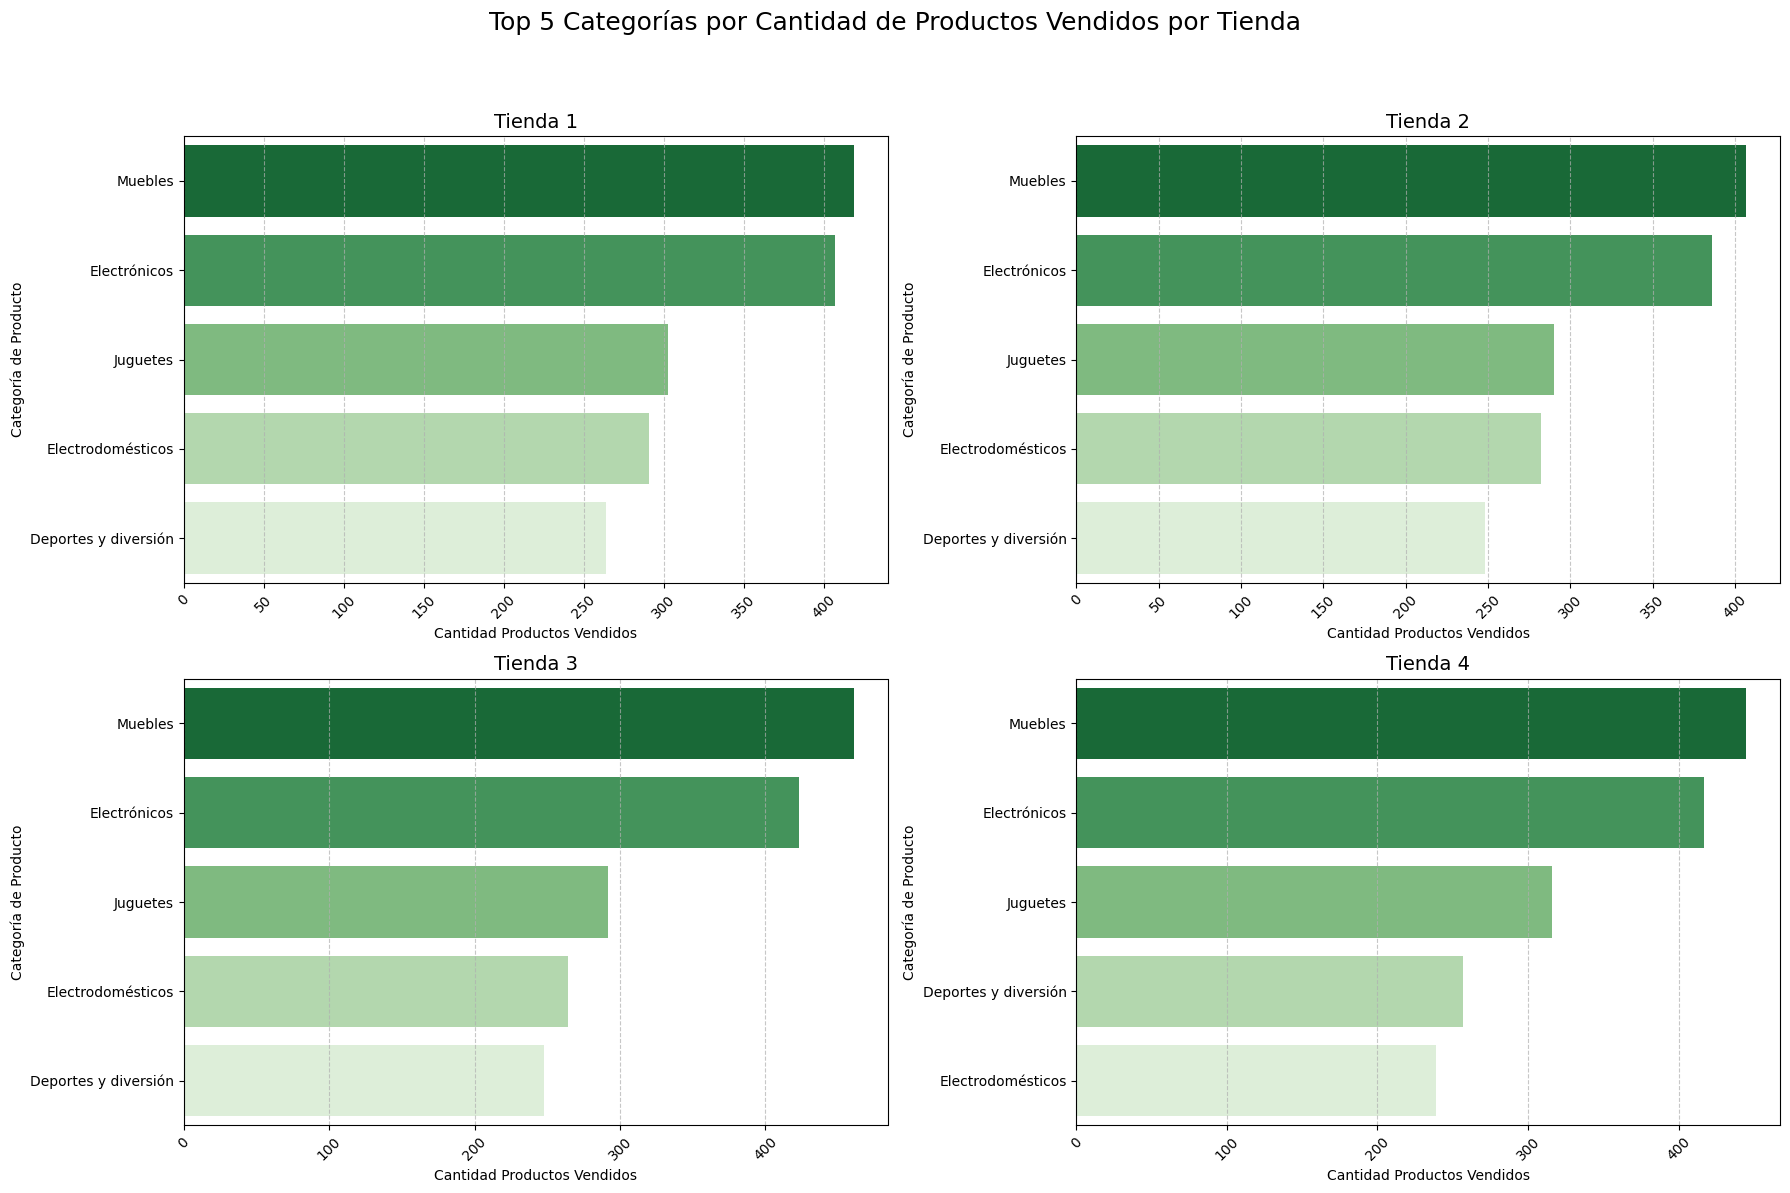

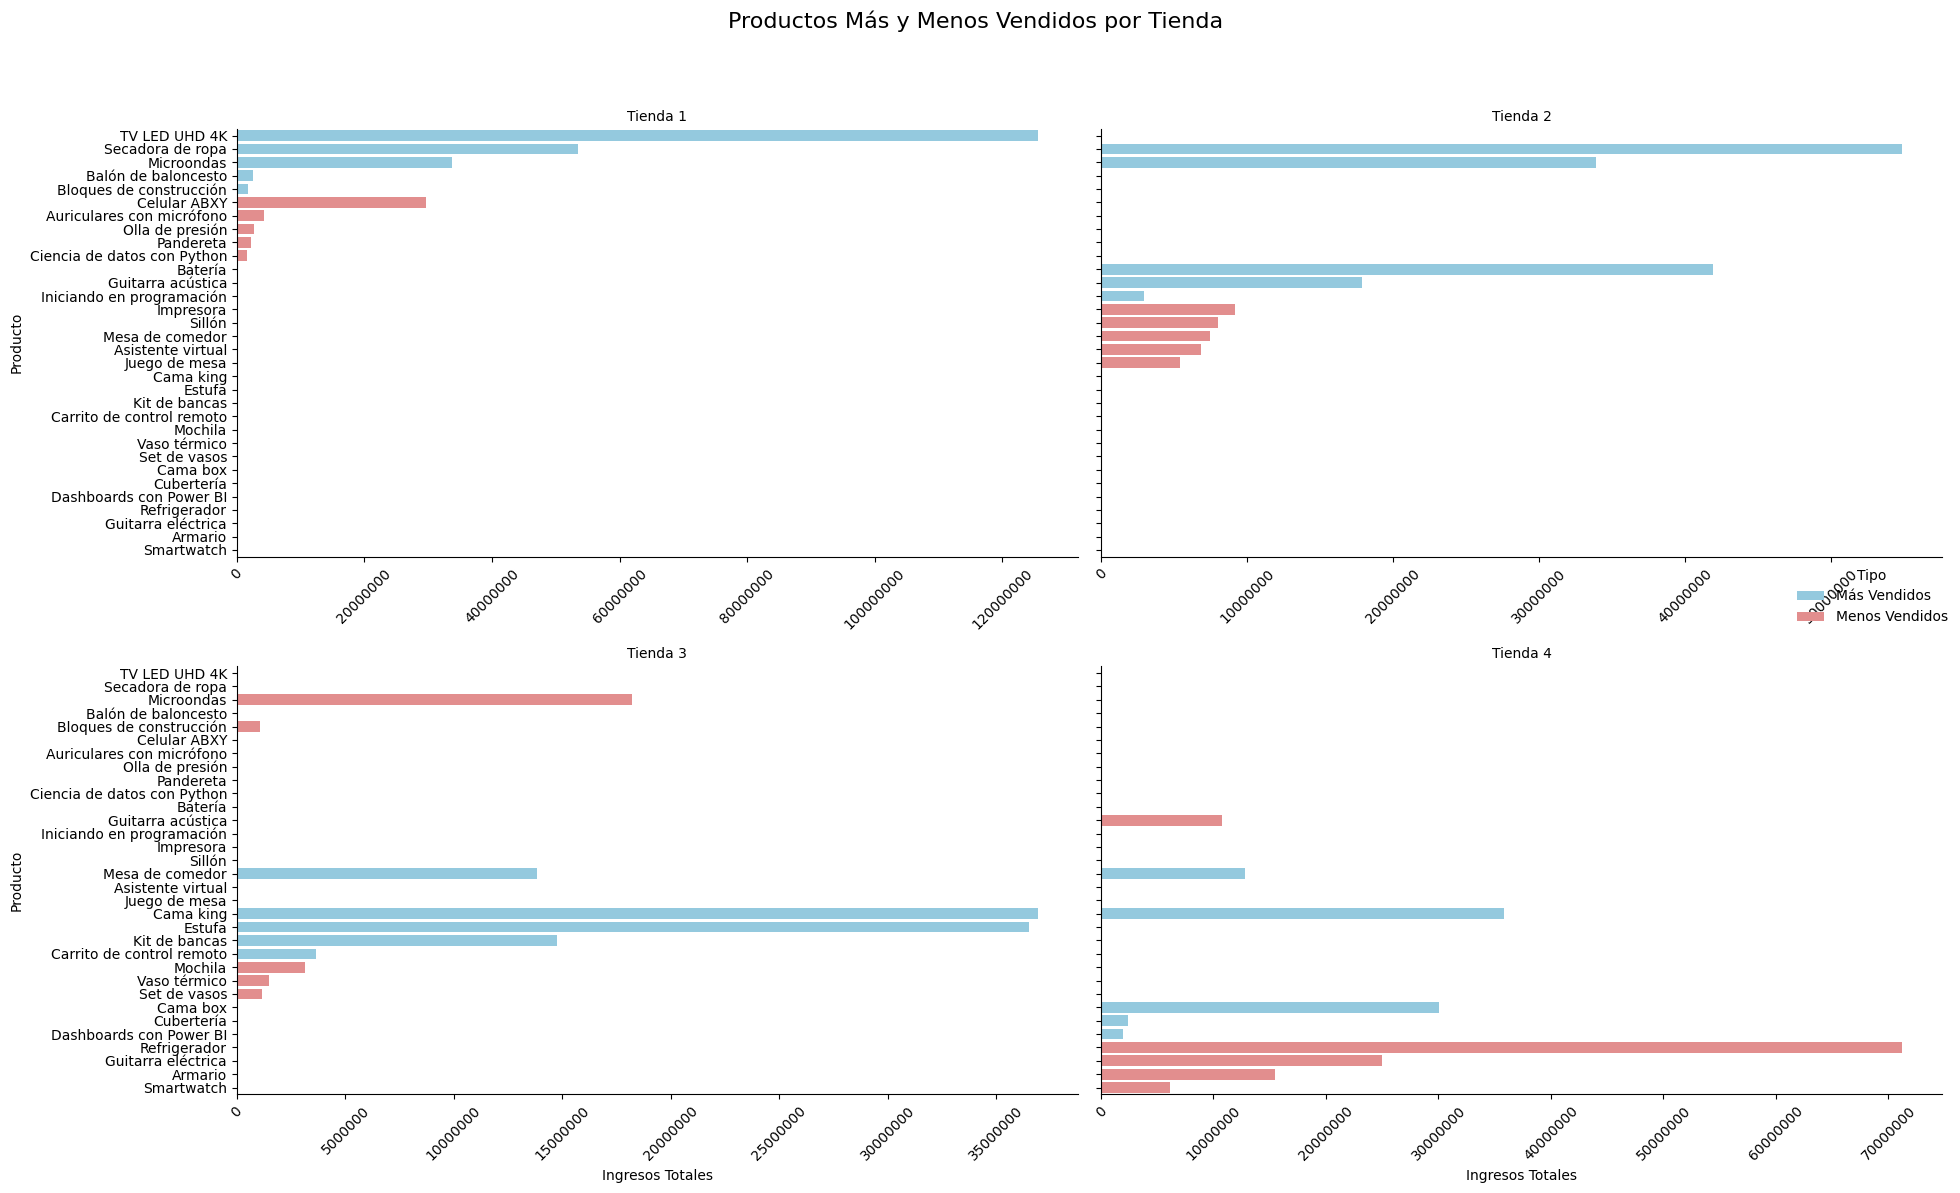

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig_cat, axes_cat = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), sharex=False, sharey=False)
fig_cat.suptitle('Top 5 Categorías por Cantidad de Productos Vendidos por Tienda', y=1.02, fontsize=18)

for i, store_id in enumerate(top5CategoriasxTienda['Tienda'].unique()):
    row = i // 2
    col = i % 2
    ax = axes_cat[row, col]
    store_data = top5CategoriasxTienda[top5CategoriasxTienda['Tienda'] == store_id].sort_values(by='CantidadProductosVendidos', ascending=False)
    sns.barplot(x='CantidadProductosVendidos', y='ProductoCategoria', data=store_data, ax=ax, palette='Greens_r', hue='ProductoCategoria', legend=False) # Fixed warning here
    ax.set_title(f'Tienda {store_id}', fontsize=14)
    ax.set_xlabel('Cantidad Productos Vendidos', fontsize=10)
    ax.set_ylabel('Categoría de Producto', fontsize=10)
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

top5ProductosMasVendidos['Tipo'] = 'Más Vendidos'
top5ProductosMenosVendidos['Tipo'] = 'Menos Vendidos'

combined_products = pd.concat([top5ProductosMasVendidos, top5ProductosMenosVendidos])
combined_products_sorted = combined_products.sort_values(by=['Tienda', 'Tipo', 'TrnVenta'], ascending=[True, False, False])

g = sns.catplot(
    data=combined_products_sorted,
    x='TrnVenta',
    y='Producto',
    hue='Tipo',
    col='Tienda',
    kind='bar',
    col_wrap=2,
    sharex=False,
    height=6, aspect=1.5,
    palette={'Más Vendidos': 'skyblue', 'Menos Vendidos': 'lightcoral'}
)

g.set_axis_labels('Ingresos Totales', 'Producto')
g.set_titles('Tienda {col_name}')

for ax in g.axes.flat:
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('Productos Más y Menos Vendidos por Tienda', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Análisis de Inventarios de Productos Vendidos: Este análisis nos permitirá entender qué tipos de productos impulsan las ventas y cuáles podrían estar lastrando el rendimiento, especialmente en la Tienda 4.
Categorías Más Vendidas por Tienda:
•	Tiendas 1, 2, 3 y 4: Las categorías de Electrónicos, Electrodomésticos y Muebles son consistentemente las más vendidas en términos de ingresos y cantidad de productos en todas las tiendas, reflejando su alta demanda.
•	Observación de Tienda 4: Aunque Electrónicos es su categoría principal, la Tienda 4 muestra un menor volumen de ventas en Electrodomésticos en comparación con las otras tiendas (239 unidades frente a 291, 282, 264 en Tiendas 1, 2, 3 respectivamente), lo que contribuye a sus menores ingresos generales.

Productos Más Vendidos por Tienda:
•	Tienda 1: Destacan "TV LED UHD 4K" (53 transacciones, 125.5M) y "Secadora de ropa" (53 transacciones, 53.4M).
•	Tienda 2: "Secadora de ropa" (53 transacciones, 54.8M) y "Batería" (55 transacciones, 41.9M) lideran las ventas.
•	Tienda 3: "Cama king" (53 transacciones, 36.9M) y "Estufa" (51 transacciones, 36.5M) son los productos con mayores ventas.
•	Tienda 4: Sus productos más vendidos incluyen "Cama king" (54 transacciones, 35.8M) y "Cama box" (57 transacciones, 30.0M). Aunque tiene un buen volumen de transacciones en estos productos, los ingresos generados son comparables o ligeramente inferiores a los de las otras tiendas en sus respectivos productos principales.
Productos Menos Vendidos por Tienda:
•	Tienda 1: "Celular ABXY" (30 transacciones, 29.6M) y "Auriculares con micrófono" (30 transacciones, 4.2M) se encuentran entre los menos vendidos.
•	Tienda 2: "Impresora" (30 transacciones, 9.2M) y "Sillón" (33 transacciones, 7.9M) tienen un bajo rendimiento.
•	Tienda 3: "Microondas" (34 transacciones, 18.2M) y "Mochila" (32 transacciones, 3.1M) están en la parte inferior.
•	Tienda 4: Entre sus productos con menor rendimiento se encuentran "Refrigerador" (36 transacciones, 71.2M), "Guitarra eléctrica" (32 transacciones, 24.9M) y "Armario" (32 transacciones, 15.4M). Llama la atención que el "Refrigerador", siendo un producto de alto valor, tenga un número bajo de transacciones en la Tienda 4, lo que sugiere una posible ineficiencia en la venta de productos de mayor margen o una demanda limitada para este producto específico en su base de clientes.

Las tendencias generales de las categorías más vendidas son similares en todas las tiendas, indicando que la demanda de Electrónicos, Electrodomésticos y Muebles es fuerte en toda la cadena. Sin embargo, la Tienda 4 muestra una debilidad en la categoría de Electrodomésticos, reflejada en un menor volumen de ventas. Además, su lista de productos menos vendidos incluye artículos de alto valor como el "Refrigerador" y la "Guitarra eléctrica" con un bajo número de transacciones, lo que podría indicar problemas en el inventario, estrategias de marketing o la ubicación de la tienda que no atrae a los compradores de estos productos de mayor valor. Esta ineficiencia en la venta de productos que podrían generar mayores ingresos contribuye a su bajo rendimiento general.




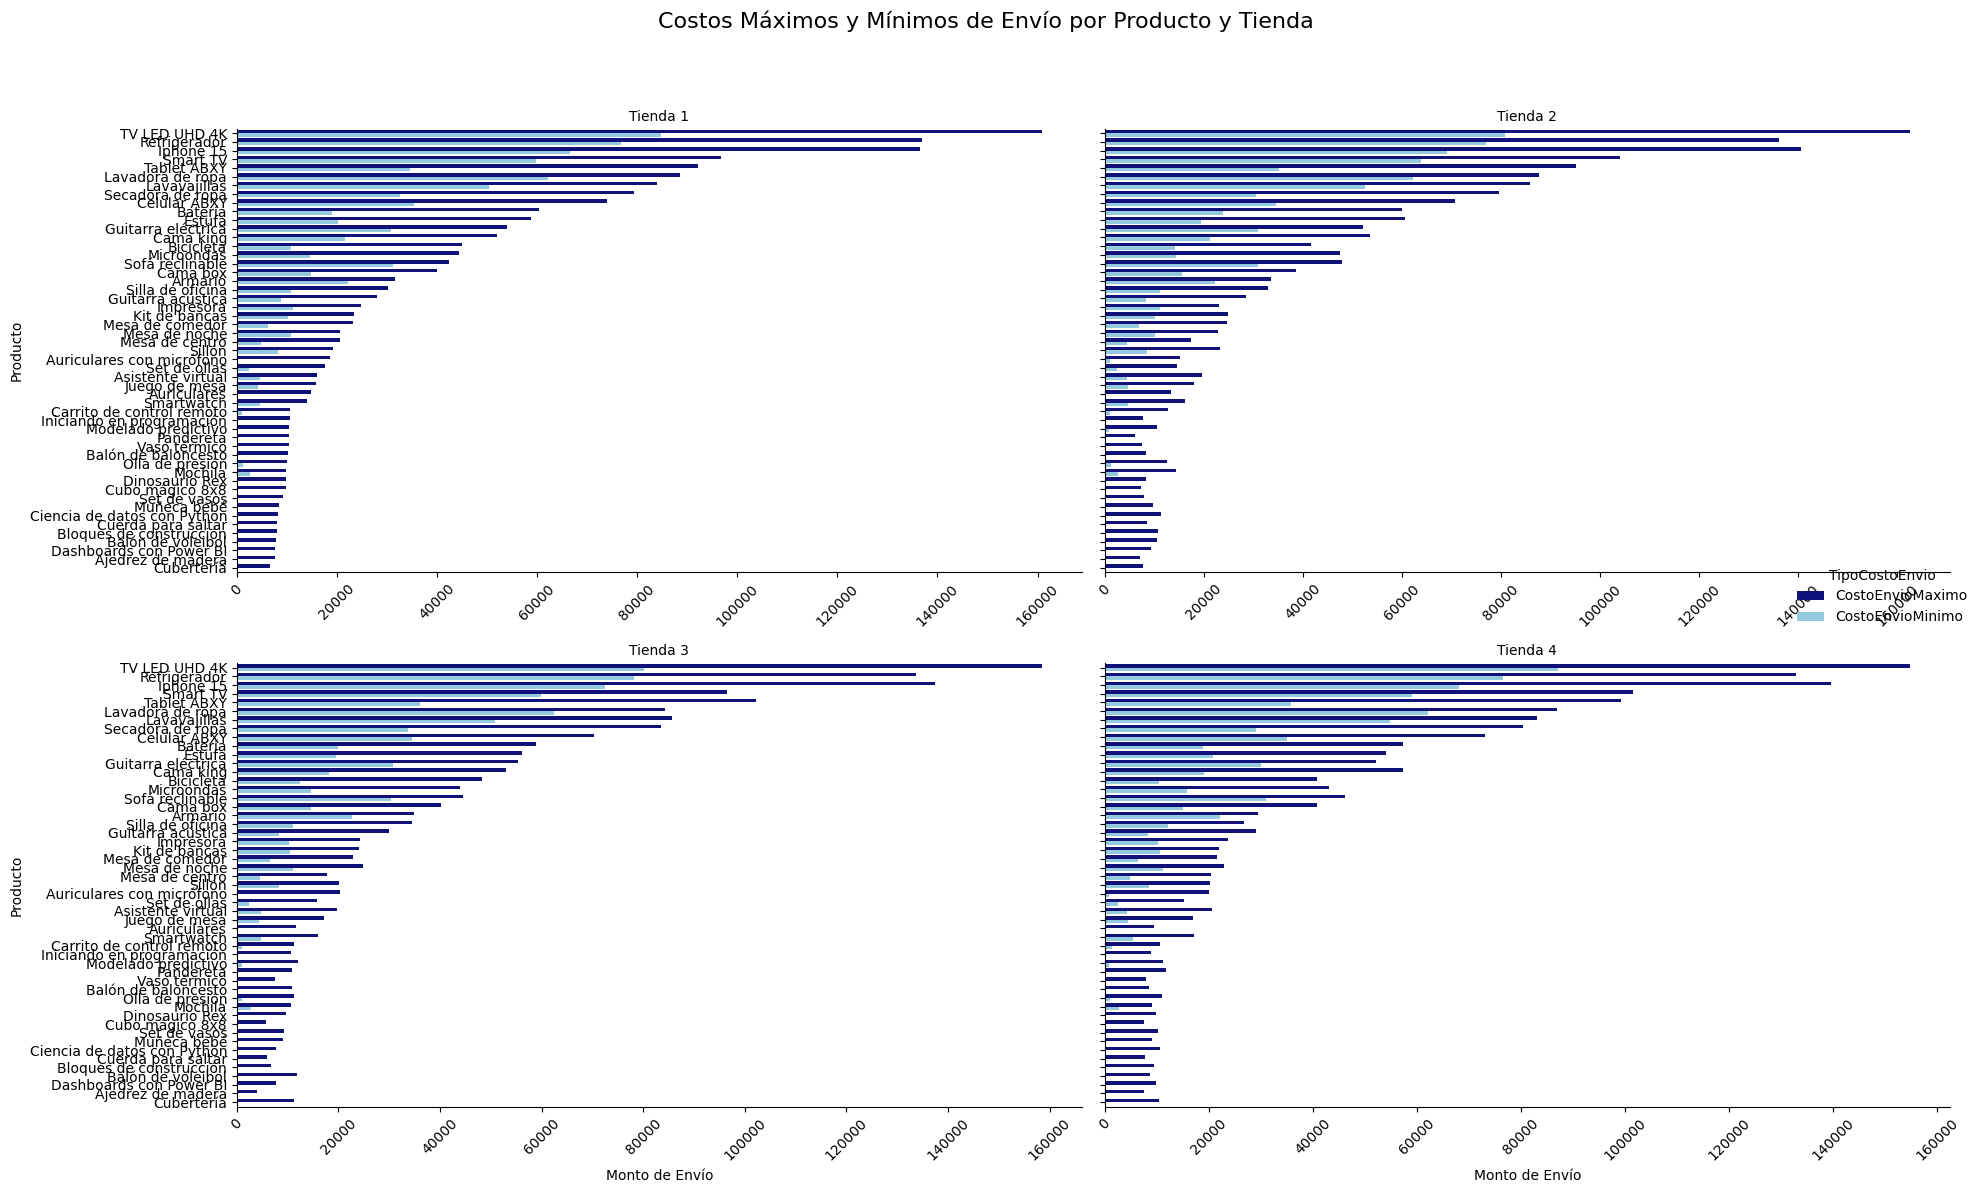

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

shipping_costs_melted = base_rendimiento_tienda_desglosado.melt(
    id_vars=['Tienda', 'Producto'],
    value_vars=['CostoEnvioMaximo', 'CostoEnvioMinimo'],
    var_name='TipoCostoEnvio',
    value_name='MontoEnvio'
)

shipping_costs_melted_sorted = shipping_costs_melted.sort_values(
    by=['Tienda', 'TipoCostoEnvio', 'MontoEnvio'],
    ascending=[True, True, False]
)

g = sns.catplot(
    data=shipping_costs_melted_sorted,
    x='MontoEnvio',
    y='Producto',
    hue='TipoCostoEnvio',
    col='Tienda',
    kind='bar',
    col_wrap=2,
    sharex=False,
    height=6, aspect=1.5,
    palette={'CostoEnvioMaximo': 'darkblue', 'CostoEnvioMinimo': 'skyblue'}
)

g.set_axis_labels('Monto de Envío', 'Producto')
g.set_titles('Tienda {col_name}')

for ax in g.axes.flat:
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('Costos Máximos y Mínimos de Envío por Producto y Tienda', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

La **Tienda 4** se destaca por tener el promedio de costos de envío más bajo (23754.29), lo que es un indicador positivo de eficiencia operativa en este aspecto. Sin embargo, esto no ha sido suficiente para compensar su bajo rendimiento en ingresos y satisfacción. Las Tiendas 1, 2 y 3 tienen promedios de costos de envío ligeramente más altos, con la Tienda 1 registrando el más alto (25762.90).
*   Ciudades como **Armenia** muestran un rango muy amplio, con la Tienda 4 teniendo un costo de envío promedio de 1600.00, mientras que la Tienda 2 tiene 58666.67. Esta disparidad sugiere que la eficiencia en los costos de envío puede ser muy específica de la combinación tienda-ciudad. La Tienda 4 parece tener una ventaja en términos de costos en varias ciudades.
*   En **Bogotá**, los costos son más consistentes entre tiendas, pero aún con variaciones (e.g., Tienda 3 con 28545.92 y Tienda 1 con 25556.12). Estas diferencias podrían deberse a la optimización de rutas, acuerdos con transportistas o volúmenes de envío.
*   **Productos de Alto Valor/Volumen**: Productos como "TV LED UHD 4K" y "Refrigerador" presentan costos de envío máximos muy elevados (superando los 100,000 en varias tiendas), reflejando su tamaño o fragilidad. Los costos mínimos para estos productos también son considerables.
*   **Productos de Bajo Valor/Volumen**: Artículos como "Cubo mágico 8x8" o "Cuerda para saltar" tienen costos de envío significativamente más bajos, incluso con 0.0 en algunas transacciones, lo que sugiere promociones de envío gratuito o inclusión en envíos mayores.


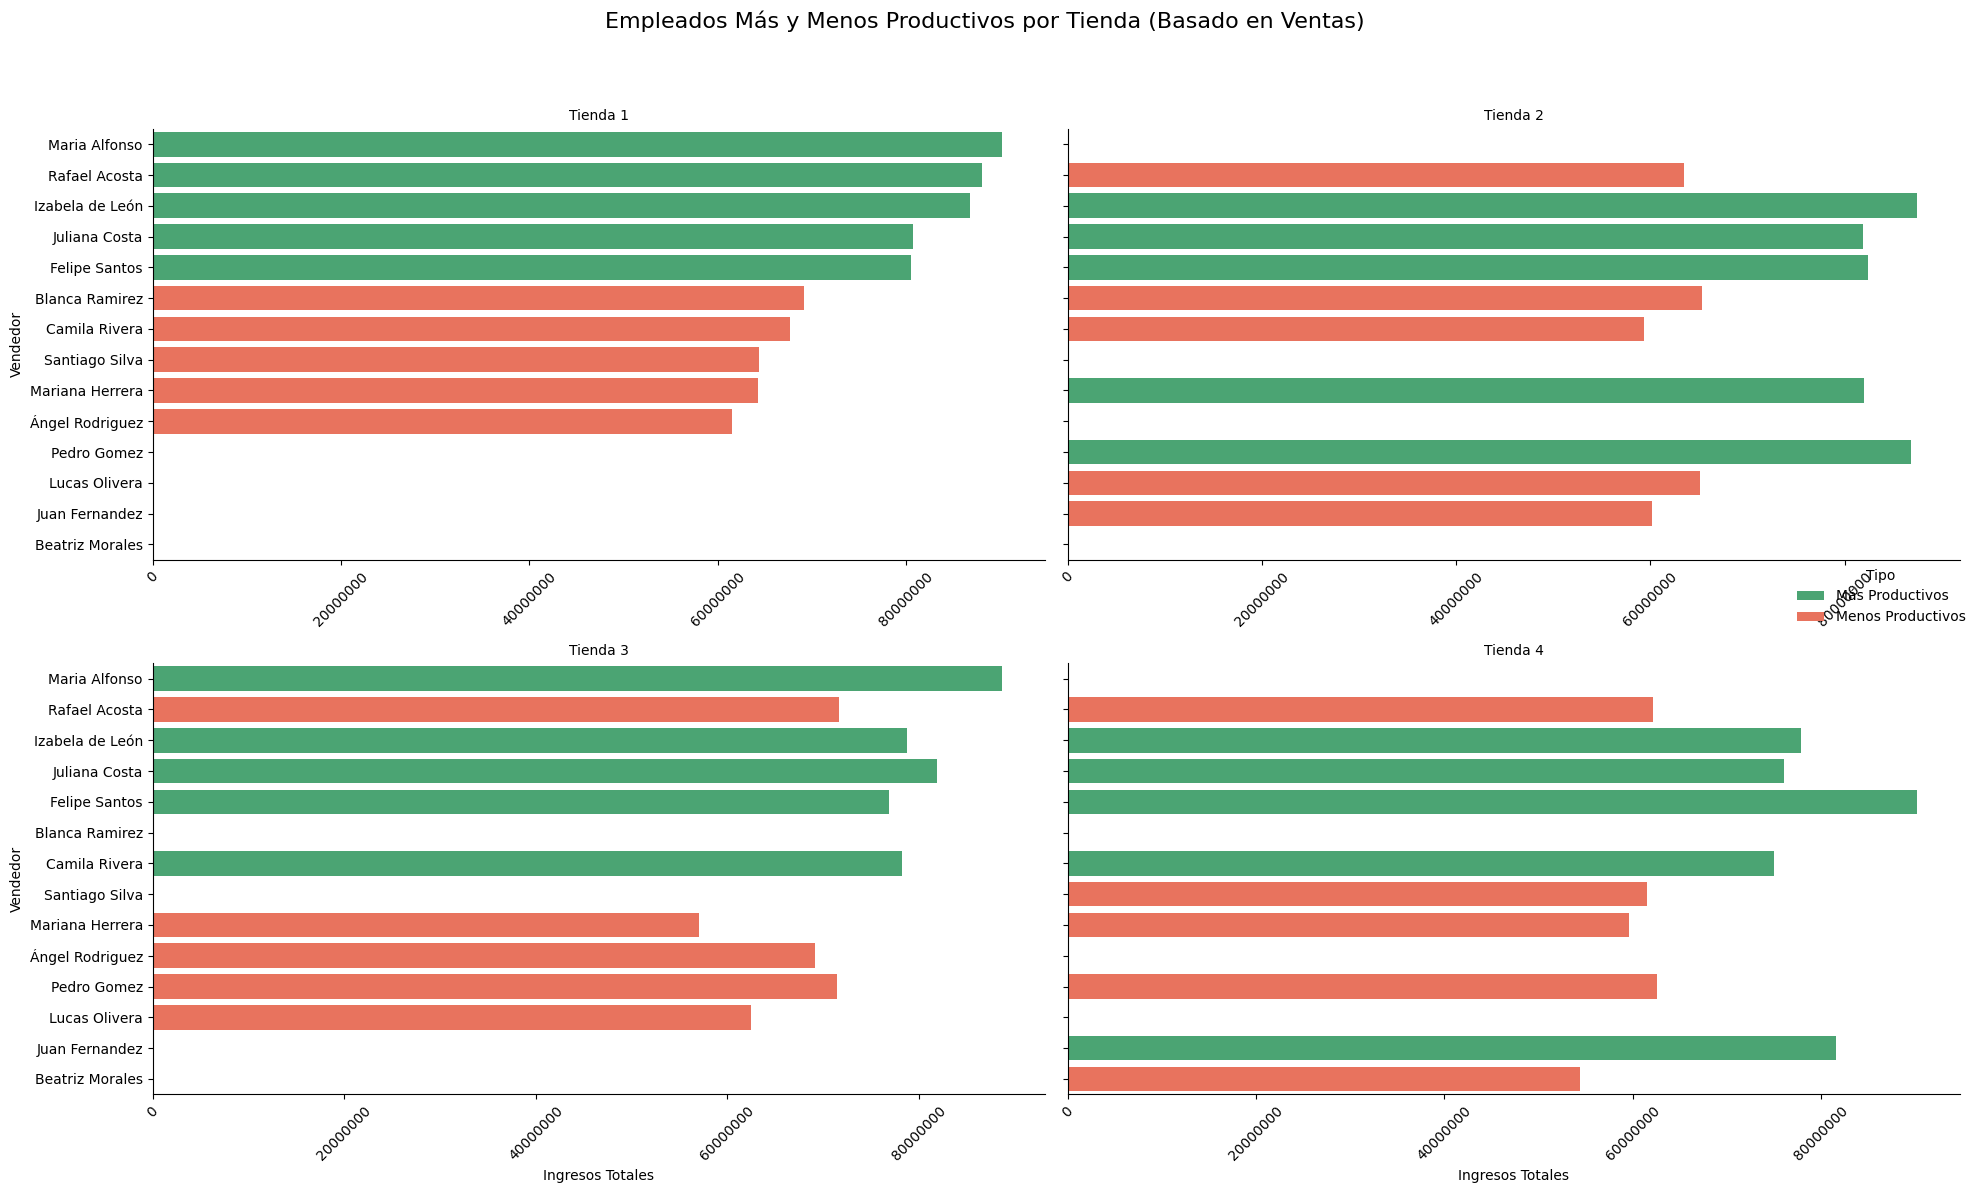

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

top5EmpleadosMasProductivos['Tipo'] = 'Más Productivos'
top5EmpleadosMenosProductivos['Tipo'] = 'Menos Productivos'

combined_empleados = pd.concat([top5EmpleadosMasProductivos, top5EmpleadosMenosProductivos])
combined_empleados_sorted = combined_empleados.sort_values(by=['Tienda', 'Tipo', 'TrnVenta'], ascending=[True, False, False])

g = sns.catplot(
    data=combined_empleados_sorted,
    x='TrnVenta',
    y='Vendedor',
    hue='Tipo',
    col='Tienda',
    kind='bar',
    col_wrap=2,
    sharex=False,
    height=6, aspect=1.5,
    palette={'Más Productivos': 'mediumseagreen', 'Menos Productivos': 'tomato'}
)

g.set_axis_labels('Ingresos Totales', 'Vendedor')
g.set_titles('Tienda {col_name}')

for ax in g.axes.flat:
    ax.ticklabel_format(style='plain', axis='x')
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('Empleados Más y Menos Productivos por Tienda (Basado en Ventas)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

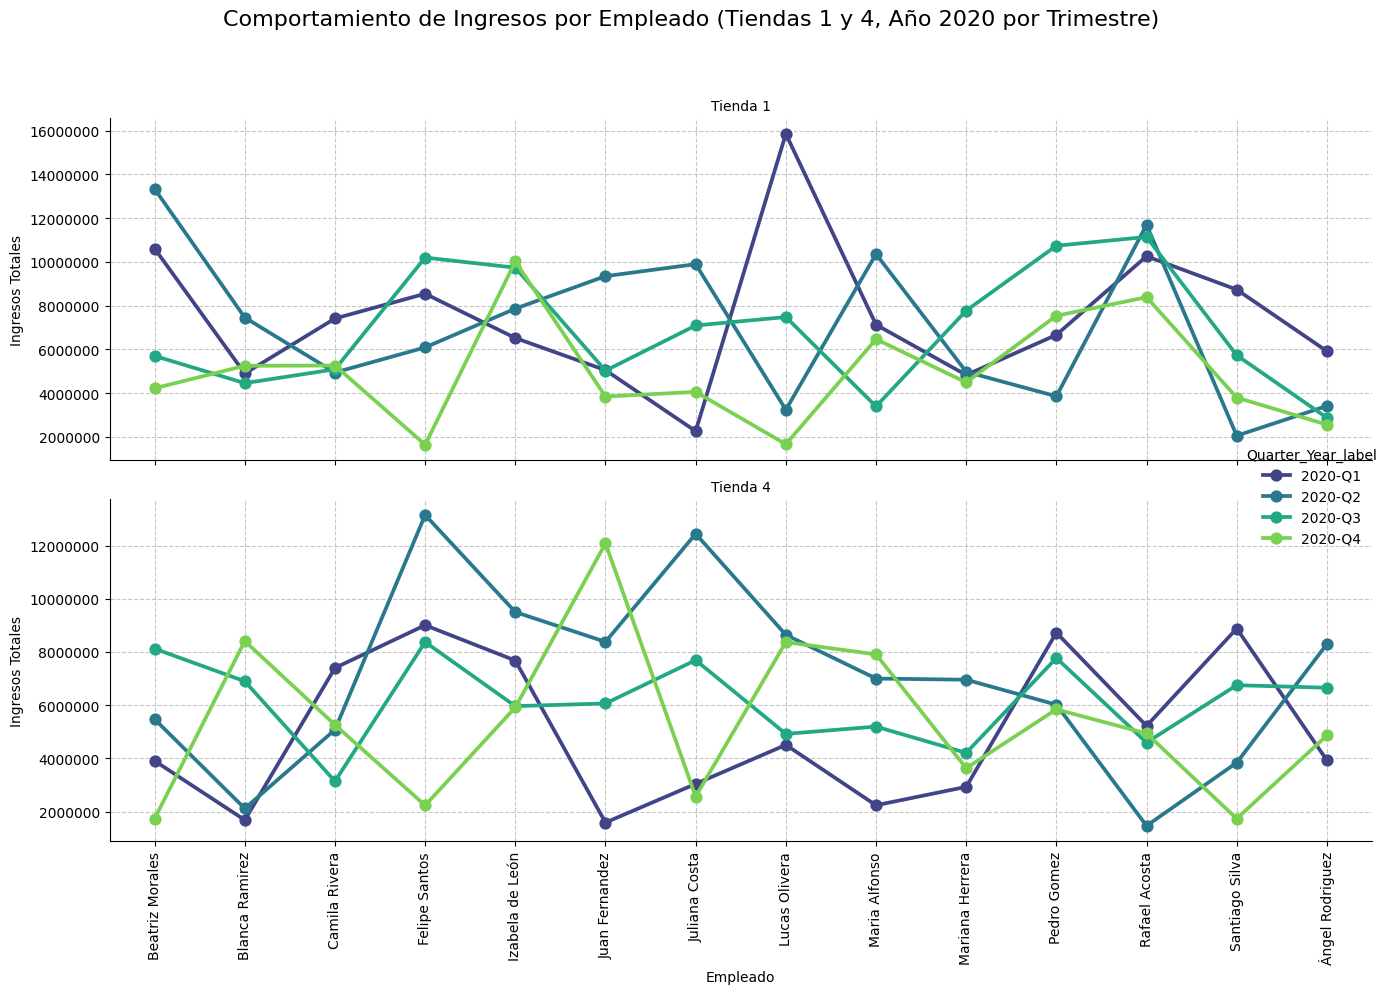

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

totalVentasxEmpleadoTrimestral['Periodo'] = totalVentasxEmpleadoTrimestral['TrnAnio'].astype(str) + '-Q' + totalVentasxEmpleadoTrimestral['TrnTrimestre'].astype(str)
filtered_data_for_plot = totalVentasxEmpleadoTrimestral[
    (totalVentasxEmpleadoTrimestral['TrnAnio'] == 2020) &
    (totalVentasxEmpleadoTrimestral['Tienda'].isin([1, 4]))
]
filtered_data_for_plot_sorted = filtered_data_for_plot.sort_values(by=['Tienda', 'TrnAnio', 'TrnTrimestre', 'Vendedor'])
filtered_data_for_plot_sorted['Quarter_label'] = 'Q' + filtered_data_for_plot_sorted['TrnTrimestre'].astype(str)
filtered_data_for_plot_sorted['Quarter_Year_label'] =  filtered_data_for_plot_sorted['TrnAnio'].astype(str)+ '-' + filtered_data_for_plot_sorted['Quarter_label']

g = sns.catplot(
    data=filtered_data_for_plot_sorted,
    x='Vendedor',
    y='TrnVenta',
    hue='Quarter_Year_label',
    row='Tienda',
    kind='point',
    height=5, aspect=2.5,
    sharey=False,
    palette='viridis'
)

g.fig.suptitle('Comportamiento de Ingresos por Empleado (Tiendas 1 y 4, Año 2020 por Trimestre)', y=1.02, fontsize=16)
g.set_axis_labels('Empleado', 'Ingresos Totales')
g.set_titles('Tienda {row_name}')

for ax in g.axes.flat:
    ax.ticklabel_format(style='plain', axis='y')
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

El análisis de comportamiento de Ventas por Empleado nos revela qué:
1. La atención de la fuerza de ventas hace que las fluctuaciones entre la Tienda 1 y Tienda 4 sigan patrones similares: por ejemplo:
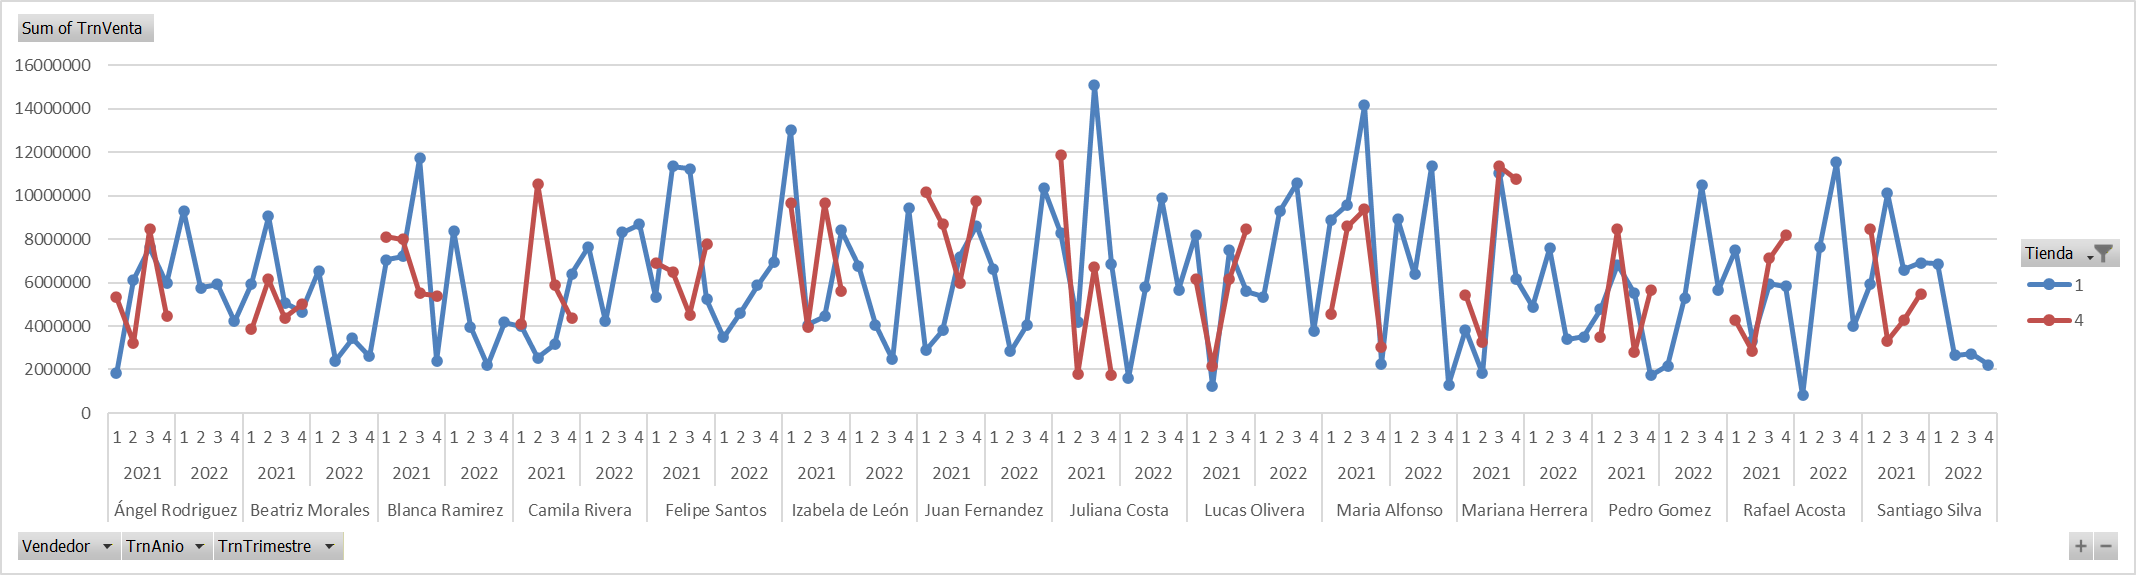

(Ángel Rodríguez) entre los trimestres de los años 2021 y 2022 se evidencia que para el 2022 no tuvo ninguna transacción para la Tienda 4 pero se mantiene atendiendo la Tienda 1. En general todos los empleados dedicaron sus esfuerzos de ventas a la Tienda 1 haciendo eventualmente movimientos en la Tienda 2 a fin de mantener un margen relativo de ventas. Esto si afectó directamente los ingresos de la Tienda 4, por lo que actualmente se tiene como la de más bajo rendimiento.

**Empleados Más Productivos por Tienda:**

*   **Tienda 1:** Maria Alfonso, Rafael Acosta, Izabela de León, Juliana Costa y Felipe Santos son los vendedores con mayores ingresos. Maria Alfonso destaca con 90.2M en ventas, representando un 8.61% del total de la tienda.
*   **Tienda 2:** Izabela de León, Felipe Santos, Juan Fernandez, Juliana Costa y Maria Alfonso lideran en ventas. Izabela de León sobresale con 87.5M en ventas, un 8.5% del total de la tienda.
*   **Tienda 3:** Rafael Acosta, Lucas Olivera, Blanca Ramirez, Maria Alfonso y Mariana Herrera son los más productivos. Rafael Acosta encabeza con 88.6M en ventas, un 8.56% del total.
*   **Tienda 4:** Los vendedores con mejor rendimiento son Rafael Acosta, Izabela de León, Juan Fernandez, Lucas Olivera y Juliana Costa. Rafael Acosta tiene las ventas más altas con 78.4M, que es el 8.0% de las ventas de la tienda.

Se observa que algunos vendedores como Maria Alfonso, Izabela de León, Felipe Santos, Juan Fernandez, Juliana Costa, Lucas Olivera y Rafael Acosta son consistentemente de los más productivos en varias tiendas, lo que sugiere una alta capacidad de venta y adaptabilidad.

**Empleados Menos Productivos por Tienda:**

*   **Tienda 1:** Blanca Ramirez, Camila Rivera, Santiago Silva, Mariana Herrera y Ángel Rodriguez tienen los ingresos más bajos. Ángel Rodriguez es el de menor rendimiento con 61.5M, un 5.88% del total de la tienda.
*   **Tienda 2:** Blanca Ramirez, Camila Rivera, Santiago Silva, Mariana Herrera y Ángel Rodriguez también aparecen en esta lista. Ángel Rodriguez es el de menor rendimiento con 60.1M, un 5.84% del total de la tienda.
*   **Tienda 3:** Beatriz Morales, Camila Rivera, Santiago Silva, Ángel Rodriguez y Bianca García se encuentran entre los menos productivos. Bianca García registra las ventas más bajas con 66.8M, un 6.46% del total.
*   **Tienda 4:** Los vendedores con menor rendimiento son Beatriz Morales, Blanca Ramirez, Mariana Herrera, Santiago Silva y Camila Rivera. Camila Rivera es la de menor rendimiento con 48.0M, un 4.9% del total de la tienda.

Es notable que varios vendedores, como Blanca Ramirez, Camila Rivera, Santiago Silva, Mariana Herrera y Ángel Rodriguez, aparecen frecuentemente en la lista de los menos productivos en múltiples tiendas, lo que podría indicar la necesidad de capacitación adicional, reevaluación de sus estrategias o la asignación a diferentes roles. La Tienda 4, en particular, tiene el vendedor con el porcentaje de ventas más bajo (Camila Rivera con 4.9%), lo que se alinea con el bajo rendimiento general de esta tienda.




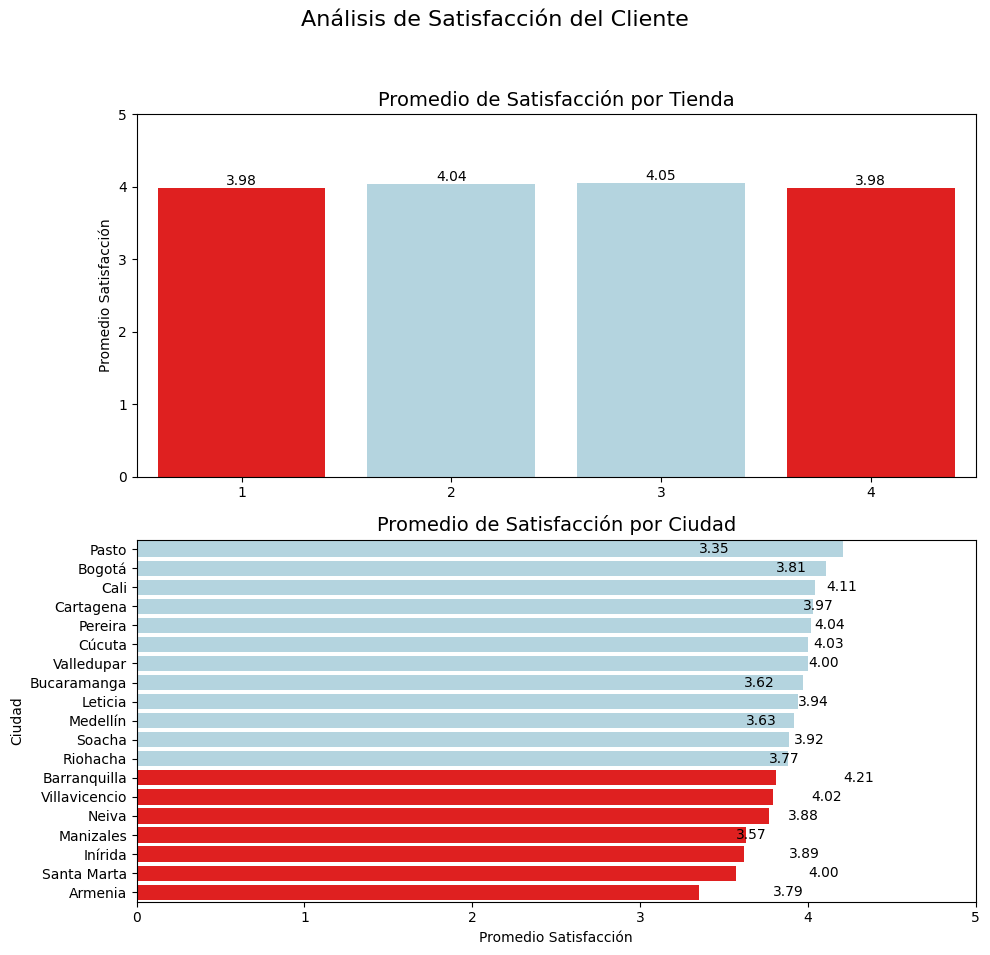

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
fig.suptitle('Análisis de Satisfacción del Cliente', fontsize=16)

# Plot 1: Promedio de Satisfacción por Tienda
promedio_satisfaccion_tienda = base_rendimiento_tienda[['TIENDA','PROMEDIO_SATISFACCION']]
global_avg_satisfaccion = promedio_satisfaccion_tienda['PROMEDIO_SATISFACCION'].mean()
colors_store_satisfaction = ['red' if val < global_avg_satisfaccion else 'lightblue' for val in promedio_satisfaccion_tienda['PROMEDIO_SATISFACCION']]

sns.barplot(x='TIENDA', y='PROMEDIO_SATISFACCION', data=promedio_satisfaccion_tienda, ax=axes[0], palette=colors_store_satisfaction, hue='TIENDA', legend=False)
axes[0].set_title('Promedio de Satisfacción por Tienda', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Promedio Satisfacción')
axes[0].set_ylim(0, 5)
for index, row in promedio_satisfaccion_tienda.iterrows():
    axes[0].text(index, row['PROMEDIO_SATISFACCION'], f'{row['PROMEDIO_SATISFACCION']:.2f}', color='black', ha="center", va='bottom')

# Plot 2: Promedio de Satisfacción por Ciudad
satisfaccion_por_TiendaCiudad_sorted = satisfaccion_por_TiendaCiudad.sort_values(by='TrnCalificacion', ascending=False)
global_avg_city_satisfaction = satisfaccion_por_TiendaCiudad['Promedio'].iloc[0]
colors_city_satisfaction = ['red' if val < global_avg_city_satisfaction else 'lightblue' for val in satisfaccion_por_TiendaCiudad_sorted['TrnCalificacion']]

sns.barplot(x='TrnCalificacion', y='TrnCiudadDestino', data=satisfaccion_por_TiendaCiudad_sorted, ax=axes[1], palette=colors_city_satisfaction, hue='TrnCiudadDestino', legend=False)
axes[1].set_title('Promedio de Satisfacción por Ciudad', fontsize=14)
axes[1].set_xlabel('Promedio Satisfacción')
axes[1].set_ylabel('Ciudad')
axes[1].set_xlim(0, 5)
for index, row in satisfaccion_por_TiendaCiudad_sorted.iterrows():
    axes[1].text(row['TrnCalificacion'], index, f'{row['TrnCalificacion']:.2f}', color='black', ha="left", va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

La **Tienda 4** registra el promedio de satisfacción más bajo (3.98), empatando con la Tienda 1. Este bajo índice de satisfacción, combinado con sus ingresos totales más bajos a pesar de un mayor número de transacciones, refuerza la conclusión de que la Tienda 4 es la menos eficiente. La insatisfacción del cliente puede llevar a la pérdida de clientes recurrentes y a una menor recomendación boca a boca, lo que impacta directamente en los ingresos. Además, si los clientes están insatisfechos con productos de alto valor como el Refrigerador (identificado como menos vendido en Tienda 4), esto podría afectar aún más sus ingresos.
Las **Tiendas 3 y 2** presentan los índices de satisfacción más altos (4.05 y 4.04 respectivamente), superando el promedio global de 4.01. Las **Tiendas 1 y 4** comparten el promedio de satisfacción más bajo (3.98), lo que las sitúa por debajo del promedio.

*   **Mayores Índices**: Ciudades como Pasto (4.21), Bogotá (4.11), y Cali (4.04) muestran los promedios de satisfacción más altos. Esto podría indicar que los clientes en estas ciudades tienen experiencias más positivas en general, o que las tiendas que operan en ellas están gestionando mejor la satisfacción.
*   **Menores Índices**: Armenia (3.35) y Santa Marta (3.57) tienen los promedios de satisfacción más bajos. Esto podría ser una señal de problemas específicos en la entrega, calidad del producto o servicio al cliente en estas localidades, independientemente de la tienda que opere allí.
Los promedios de satisfacción por vendedor oscilan entre 3.85 (Izabela de León) y 4.13 (Ángel Rodriguez), con un promedio general de 4.015. Vendedores como Ángel Rodriguez (4.13), Mariana Herrera (4.09), y Rafael Acosta (4.09) se destacan por tener altos índices de satisfacción, mientras que Izabela de León (3.85) tiene el más bajo. Esto sugiere que el rendimiento individual de los vendedores puede influir significativamente en la percepción del cliente y que hay oportunidades de capacitación o reasignación.

## 5. Contexto y Recomendaciones

# Contexto del análisis para Alura's Store
El presente análisis se centro en la revisión de la eficiencia operativa de las cuatro tiendas de Alura Store, bajo las perspectivas de Ingresos, Satisfacción del Cliente, Costos de Emvío, Manejo de Productos y Comportamiento de la fuerza de venta.

Considerando que cada una de las tiendas representan el 25% de ingresos y que durante el análisis se detectaron algunos patrones que han influido negativamente en el rendimiento de las tiendas se hacen las  siguientes consideraciones:

# Recomendaciones

## Alternativa 1 - Venta - (Evaluar)
1. Considerando los indicadores de ingresos de cada tienda:
--
***La TIENDA #4***
--
Es la candidata para ser considerada para su cierre. Aunque representa el 24%  de las ventas tiene serias deficiencias en cuanto a fuerza de venta que no hace que la operación sea regular. Aunque tiene indices de satisfacción bajos (** similares a la tienda 1 que es la de mejores indicadores de venta **), que sus costos de envío son los mejores y que el inventario de productos hace que el más del 60% de sus ventas estén entre los productos y categorías de sus tiendas homologas, se ha detectado que no han sido los factores determinantes de sus bajos Ingresos.

***Puntualmente la afectación de sus ventas están originadas en la atención de su fuerza de venta que durante el año 2022 prácticamente mantuvieron las transacciones de está tienda sin actividad, en ocasiones pareciera se relevan entre ellos para hacer ventas eventuales y mantener los números globales cercanos a los de las otras tiendas.***

## Alternativa 2 - Reestructuración - (Recomendada)
1. Hacer una reestructuración interna en la forma de distribuir la fuerza de ventas, a fin de que todas las tiendas sean atendidas de forma ininterrupida.
2. Hacer una evaluación de la estrategia de ventas de acuerdo a las preferencias de los clientes a fin de establecer mejores promociones de acuerdo a las zonas de alcance de ventas.
3. Mantener el monitoreo de satisfacción de los clientes a fin de determinar quienes de los vendedores requieren capacitación.
4. Hacer un plan de alcance de metas de venta a 6 meses y monitorear a fin de verificar que las estrategias han sido efectivas y que la proyección de ventas nos permita alcanzar y nivelar todas las tiendas.
5. La clave para desarrollar las estrategias están en evaluar los patrones de la  tienda 1 y 4, ya que comparten muchas oportunidades de mejora.

# Nota importante
En caso de selección de cualquiera de las dos alternativas es necesario que se evalue:
1. La revisión y reestructuracion de las policitcas y procedimientos de  ventas.
2. La capacitación de los empleados.
3. Evaluación de la razón del porque la brecha de venta entre los empleados que se encuentran en el top y los de menores ventas es tan amplia. Por ejemplo, en la Tienda 1, la diferencia entre Maria Alfonso (90.2M) y Ángel Rodriguez (61.5M) es de casi 29M, lo que indica que una mejora en el rendimiento de los vendedores de bajo desempeño podría tener un impacto sustancial en los ingresos de la tienda.
4. Evaluar las politicas de costos de envío y su aplicación
5. Hacer un sondeo de satisfacción para los clientes de las tiendas 1 y 4 a fin de determinar mejores estrategias de atención al cliente.